In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score
from IPython.display import clear_output

# Load the CSV File
file_path = "tournament_decks.csv"
data = pd.read_csv(file_path)
data

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards
0,https://limitlesstcg.com/tournaments/jp/1839,1-3,milotic,farigiraf,https://limitlesstcg.com/decks/list/jp/27337,1,P#Feebas#3#https://limitlesstcg.com/cards/SSP/...
1,https://limitlesstcg.com/tournaments/jp/1839,だいくん。,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27338,2,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
2,https://limitlesstcg.com/tournaments/jp/1839,omochikun,xatu,espathra,https://limitlesstcg.com/decks/list/jp/27339,3,P#Natu#3#https://limitlesstcg.com/cards/PAR/71...
3,https://limitlesstcg.com/tournaments/jp/1839,セラ,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27340,4,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
4,https://limitlesstcg.com/tournaments/jp/1839,伸び代のペリ,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/27341,5,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
...,...,...,...,...,...,...,...
8281,https://limitlesstcg.com/tournaments/jp/2365,まいと,gholdengo,typhlosion,https://limitlesstcg.com/decks/list/jp/35516,12,P#Gimmighoul#4#https://limitlesstcg.com/cards/...
8282,https://limitlesstcg.com/tournaments/jp/2365,けんT,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35517,13,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
8283,https://limitlesstcg.com/tournaments/jp/2365,びゃくや,noctowl,ogerpon-wellspring,https://limitlesstcg.com/decks/list/jp/35518,14,P#Hoothoot#3#https://limitlesstcg.com/cards/SC...
8284,https://limitlesstcg.com/tournaments/jp/2365,きい,ogerpon,noctowl,https://limitlesstcg.com/decks/list/jp/35519,15,P#Teal Mask Ogerpon ex#4#https://limitlesstcg....


In [2]:
# Parse the "cards" column to extract card links, counts, and types as features
def parse_cards_with_types(cards):
    card_list = cards.split('|')
    card_features = {"p": {}, "t": {}, "e": {}}
    for card in card_list:
        parts = card.split('#')
        if len(parts) >= 3:
            card_type = parts[0].lower() # Extract card type (e.g., "pokemon", "trainer", "energy")
            card_link = parts[3]         # Use the card link as the feature
            card_count = int(parts[2])   # Use the card count as the value
            if card_type in card_features:
                card_features[card_type][card_link] = card_count
    return card_features

card_features_with_types = data['cards'].apply(parse_cards_with_types)
card_features_with_types

0       {'p': {'https://limitlesstcg.com/cards/SSP/41'...
1       {'p': {'https://limitlesstcg.com/cards/TEF/123...
2       {'p': {'https://limitlesstcg.com/cards/PAR/71'...
3       {'p': {'https://limitlesstcg.com/cards/TEF/123...
4       {'p': {'https://limitlesstcg.com/cards/TWM/128...
                              ...                        
8281    {'p': {'https://limitlesstcg.com/cards/SSP/97'...
8282    {'p': {'https://limitlesstcg.com/cards/TWM/128...
8283    {'p': {'https://limitlesstcg.com/cards/SCR/114...
8284    {'p': {'https://limitlesstcg.com/cards/TWM/25'...
8285    {'p': {'https://limitlesstcg.com/cards/SVI/84'...
Name: cards, Length: 8286, dtype: object

In [3]:
# Separate features by card type
pokemon_features = card_features_with_types.apply(lambda x: x['p'])
trainer_features = card_features_with_types.apply(lambda x: x['t'])
energy_features = card_features_with_types.apply(lambda x: x['e'])

# Convert each card type into a feature matrix
vectorizer = DictVectorizer(sparse=True)
pokemon_matrix = vectorizer.fit_transform(pokemon_features)
trainer_matrix = vectorizer.fit_transform(trainer_features)
energy_matrix = vectorizer.fit_transform(energy_features)

# Weight the features by card type (adjust weights as needed)
pokemon_weight = 1.0
trainer_weight = 0.5
energy_weight = 0.2

# Combine the weighted feature matrices
X_combined = hstack([
    pokemon_matrix * pokemon_weight,
    trainer_matrix * trainer_weight,
    energy_matrix * energy_weight
])

# Normalize the combined feature matrix
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)
X_scaled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 235698 stored elements and shape (8286, 799)>

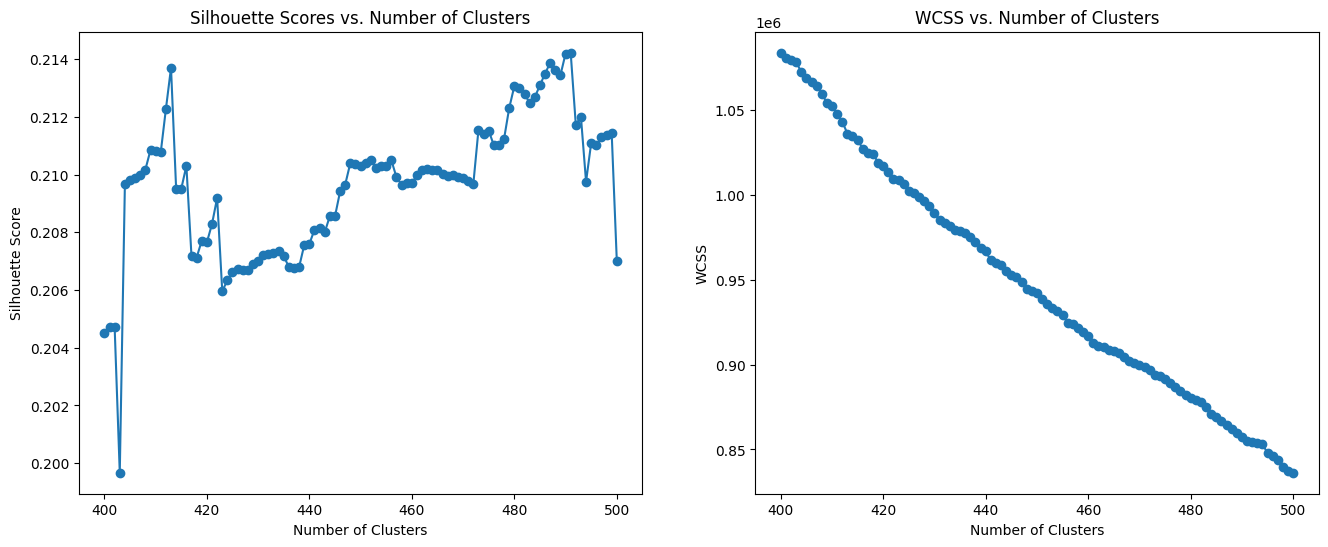

In [6]:
# Find the optimal number of clusters
start_clusters = 400
end_clusters = 500
silhouette_scores = []
wcss = []
cluster_range = range(start_clusters, end_clusters + 1)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    wcss.append(kmeans.inertia_)

    if n_clusters % 10 == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot silhouette scores
        axes[0].plot(range(start_clusters, n_clusters + 1), silhouette_scores, marker='o')
        axes[0].set_title('Silhouette Scores vs. Number of Clusters')
        axes[0].set_xlabel('Number of Clusters')
        axes[0].set_ylabel('Silhouette Score')

        # Plot WCSS
        axes[1].plot(range(start_clusters, n_clusters + 1), wcss, marker='o')
        axes[1].set_title('WCSS vs. Number of Clusters')
        axes[1].set_xlabel('Number of Clusters')
        axes[1].set_ylabel('WCSS')

        # Show the plots
        plt.show()


In [8]:
# index of max silhouette score
silhouette_scores.index(max(silhouette_scores)) + start_clusters

491

In [9]:
num_clusters = 490
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

In [10]:
# Calculate cluster statistics
cluster_stats = data.groupby('cluster').agg(
    cluster_size=('cluster', 'size'),  # Number of decks in each cluster
    mean_rank=('rank', 'mean'),       # Average rank of decks in each cluster
    min_rank=('rank', 'min'),         # Minimum rank in each cluster
    max_rank=('rank', 'max')          # Maximum rank in each cluster
).reset_index()

# Print cluster statistics
cluster_stats

,cluster,cluster_size,mean_rank,min_rank,max_rank
0,0,6,4.333333,3,6
1,1,71,8.943662,1,16
2,2,41,8.902439,1,16
3,3,46,8.978261,1,16
4,4,81,7.679012,1,16
...,...,...,...,...,...
485,485,4,6.250000,3,9
486,486,5,9.200000,4,16
487,487,7,11.000000,1,16
488,488,1,14.000000,14,14


In [24]:
# Calculate the median rank for each cluster
cluster_mean_rank = data.groupby('cluster').agg(
    mean_rank=('rank', 'mean'),  # Mean rank of decks in each cluster
    cluster_size=('cluster', 'size'), # Number of decks in each cluster
    main_pokemon=('mainpokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common main Pokemon
    secondary_pokemon=('secondarypokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common secondary Pokemon
).reset_index()

# Sort clusters by median rank
cluster_mean_rank = cluster_mean_rank.sort_values(by='mean_rank')
pd.options.display.max_rows = None
# cluster_mean_rank[(cluster_mean_rank['cluster_size'] > 30)].head(20)
# cluster_mean_rank[(cluster_mean_rank['main_pokemon'] == 'charizard') & (cluster_mean_rank['secondary_pokemon'] == 'dudunsparce')].head(20)
cluster_mean_rank[((cluster_mean_rank['main_pokemon'] == 'charizard') | (cluster_mean_rank['secondary_pokemon'] == 'charizard')) & (cluster_mean_rank['cluster_size'] > 10)].head(20)
# cluster_mean_rank[(cluster_mean_rank['cluster'] == 452)].head(20)


,cluster,mean_rank,cluster_size,main_pokemon,secondary_pokemon
139,139,6.583333,24,charizard,dudunsparce
345,345,7.076923,13,charizard,pidgeot
401,401,7.629630,27,charizard,pidgeot
489,489,7.813333,75,noctowl,charizard
16,16,8.090323,155,charizard,noctowl
452,452,8.288462,52,charizard,pidgeot
266,266,8.426230,61,charizard,pidgeot
445,445,8.592593,27,dragapult,charizard
11,11,8.906250,64,dragapult,charizard
337,337,9.164706,85,noctowl,charizard


In [28]:
# Sort values by rank then by tournamenturl
data[data['cluster'] == 452].sort_values(by=['rank', 'tournamenturl'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
6803,https://limitlesstcg.com/tournaments/jp/2273,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34052,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
6755,https://limitlesstcg.com/tournaments/jp/2270,おおくぼ,charizard,noctowl,https://limitlesstcg.com/decks/list/jp/34005,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
6395,https://limitlesstcg.com/tournaments/jp/2247,えぬえぬ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33651,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
5644,https://limitlesstcg.com/tournaments/jp/2198,カネケン,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32907,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
2363,https://limitlesstcg.com/tournaments/jp/1991,こあら,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/29673,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
628,https://limitlesstcg.com/tournaments/jp/1882,ソーダ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/27955,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
7715,https://limitlesstcg.com/tournaments/jp/2330,カッター,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34954,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
5725,https://limitlesstcg.com/tournaments/jp/2203,さけ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32987,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
5034,https://limitlesstcg.com/tournaments/jp/2159,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32315,2,P#Charmander#4#https://limitlesstcg.com/cards/...,452
6869,https://limitlesstcg.com/tournaments/jp/2277,しゅか,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34118,3,P#Charmander#3#https://limitlesstcg.com/cards/...,452


In [16]:
data[data['cluster'] == 452].sort_values(by=['rank', 'cluster'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
628,https://limitlesstcg.com/tournaments/jp/1882,ソーダ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/27955,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
2363,https://limitlesstcg.com/tournaments/jp/1991,こあら,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/29673,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
5644,https://limitlesstcg.com/tournaments/jp/2198,カネケン,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32907,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
6395,https://limitlesstcg.com/tournaments/jp/2247,えぬえぬ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33651,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
6755,https://limitlesstcg.com/tournaments/jp/2270,おおくぼ,charizard,noctowl,https://limitlesstcg.com/decks/list/jp/34005,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
6803,https://limitlesstcg.com/tournaments/jp/2273,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34052,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
5034,https://limitlesstcg.com/tournaments/jp/2159,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32315,2,P#Charmander#4#https://limitlesstcg.com/cards/...,452
5725,https://limitlesstcg.com/tournaments/jp/2203,さけ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32987,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
7715,https://limitlesstcg.com/tournaments/jp/2330,カッター,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34954,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
2093,https://limitlesstcg.com/tournaments/jp/1974,きな粉もちち,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/29404,3,P#Charmander#3#https://limitlesstcg.com/cards/...,452
